<a href="https://colab.research.google.com/github/antenoraires/bar-chart-race-covid-19-Brasil-/blob/master/Feminicidio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Instalando a lib para o autoarimma
!pip install pmdarima

In [51]:
# Request é uma lib usada para request https
import requests
# Soup é a lib usada para scraping
from bs4 import BeautifulSoup
# Lib para modelagem de Dados
import pandas as pd
# Biblioteca para recursos de Data
import datetime
from dateutil.relativedelta import relativedelta
# Lib para visualização gráfica
import plotly.graph_objects as Dash
# Bibliotecas de plotagem de dados
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
# Salvar o link da pagina
Site = 'http://www.ssp.sp.gov.br/Estatistica/ViolenciaMulher.aspx'
# Fazendo o carregando da pagina atraves do Request
Pagina = requests.get(Site)
# Coletando as infos do request e passar para o Soup os dados
Coleta = BeautifulSoup(Pagina.text, 'html.parser')

In [53]:
# Colando informações das Tabelas
Tabelas = Coleta.find_all('table', attrs={'class':'table table-striped table-hover table-condensed'})
# Verificando as Tabelas localizadas
print( 'Localizado:', len(Tabelas), 'tabelas' )

Localizado: 143 tabelas


In [54]:
# Lista para salvar os dados
Rotulos = []
Dados = []
Periodos = []
# Qual o utlimo registro da Tabela
Registro_Inicial = datetime.datetime(2023, 8, 1)

# Variavel para somar pular os meses
Loop = 0
# Loop para filtrar as informações
for Consulta in Tabelas:

  # Filtrar a Linha da Tabela
  Linha = Consulta.find_all('tr')[2]

  # Filtrar o rotulo da Tabela
  Rotulo = Linha.find_all('td')[0].text

  # Filtrar a informação Geral
  Informação = Linha.find_all('span')[0].text
  # Calculando a data de registro
  Data = Registro_Inicial - relativedelta(months=Loop)

  # Caso o conteudo seja Feminicidio
  if Rotulo == 'FEMINICÍDIO':
    Rotulos.append( Rotulo )
    Dados.append( Informação )
    Periodos.append( Data )

  # Ignorando caso seja diferente
  else:
    pass

  # Somando o Loop para dar o Desagiu no Mes
  Loop = Loop + 1

# Organizando em um Dicionario os Dados
Dicionario = {
    'Rotulo' : Rotulos,
    'Quantidade' : Dados,
    'Periodo' : Periodos
}

# Passando o dicionario como base de dados
Base_Feminicídio = pd.DataFrame( Dicionario )

# Verificando as primeiras Linhas
Base_Feminicídio.head()

,Rotulo,Quantidade,Periodo
0,FEMINICÍDIO,12,2023-08-01
1,FEMINICÍDIO,10,2023-07-01
2,FEMINICÍDIO,21,2023-06-01
3,FEMINICÍDIO,19,2023-05-01
4,FEMINICÍDIO,18,2023-04-01


In [55]:
#Base_Feminicídio.to_excel('Dados_Feminicído.xlsx', index=False )

In [56]:
# Definir a coluna Data como Index do DataSet
Base_Feminicídio = Base_Feminicídio.set_index('Periodo')
# Ordenar a Data
Base_Feminicídio = Base_Feminicídio.sort_values(by='Periodo')

In [57]:
# Verificando tipo das colunas
Base_Feminicídio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2018-02-01 to 2023-08-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rotulo      67 non-null     object
 1   Quantidade  67 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


In [58]:
# Convertendo a coluna para inteiro
Base_Feminicídio['Quantidade'] = pd.to_numeric( Base_Feminicídio['Quantidade'] )

In [59]:
# Criando um Gráfico Dinâmico
# No gráfico é possivel filtrar pela legenda a informação
# Utlizar zoons

# Definindo uma figura
Figura = Dash.Figure()

# Incluindo o Eixo no Gráfico - Abertura
Figura.add_trace(Dash.Scatter(x = Base_Feminicídio.index, y = Base_Feminicídio.Quantidade,
                    mode='lines',
                    name='Quantidade',
                    marker_color = '#FF7F0E',))

# Modificando o Layout do Gráfico
Figura.update_layout(
    title='Histórico de Feminicídio - Estado de São Paulo', # Titulo
    titlefont_size = 28, # Tamanho da Fonte

    # Parametros para mexer no eixo X
    xaxis = dict(
        title='Período Histórico', # Titulo do Eixo x
        titlefont_size=16, # Tamanho fonte do Titulo
        tickfont_size=14), # Tamanho da fonte do eixo

    # Tamanho do Grafico
    height = 500,

    # Parametros para mexer no eixo y
    yaxis=dict(
        title='Quantidade', # Titulo do Eixo y
        titlefont_size=16, # Tamanho fonte do Titulo
        tickfont_size=14), # Tamanho da fonte do eixo

    # Parametros para mexer na legenda
    legend=dict(
        y=1, x=1, # Posição da Legenda
        bgcolor='rgba(255, 255, 255, 0)', # Cor de fundo
        bordercolor='rgba(255, 255, 255, 0)')) # Cor da Bornda

# Mostrando o Gráfico
Figura.show()

In [60]:
# Importar a função Auto Arima
from pmdarima.arima import auto_arima

# Criando a função do auto_Arima
Funcao_Auto_Arima = auto_arima(
    # Dados para treinar o modelo
    Base_Feminicídio['Quantidade'],
    # Periodo de inicio
    start_p=1, start_q=1,
    # Maior valor para o periodo de inicio
    max_p=6, max_q=6,
    # período para diferenciação sazonal
    m=12,
    # ordem da parte autorregressiva do modelo sazonal
    start_P=0,
    # Periodo Sacional
    seasonal=True,
    # ordem da primeira diferença
    d=1,
    # ordem da diferenciação sazonal
    D=1,
    # Visualizar a saida serie
    trace=True,
    # ignorar erros
    error_action='ignore',
    # Buscar o melhor de forma rapida
    # Se utilizar como False - será utilizando força bruta no modelo
    # Normalmente como False se tem resultados melhor
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=397.912, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=365.187, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=385.472, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=364.805, Time=0.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=379.447, Time=0.11 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=358.817, Time=0.55 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=361.179, Time=0.19 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.40 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=359.777, Time=0.54 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=358.115, Time=

In [61]:
# Verificando a melhor performance do modelo
print( Funcao_Auto_Arima.aic() )

354.20273872176364


In [62]:
# Definindo o tamanho da base de dados para treino
Tamanho = int(len(Base_Feminicídio) * 0.75)
# Separando os dados de Treino e Testes
Dados_Treino, Dados_Teste = Base_Feminicídio['Quantidade'][0:Tamanho], Base_Feminicídio['Quantidade'][Tamanho:]

In [63]:
# Treinando o Modelo com os dados de treino
Funcao_Auto_Arima.fit( Dados_Treino )

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [64]:
# Fazendo a previsão
Previsao = Funcao_Auto_Arima.predict( n_periods=len(Dados_Teste) )

# Incluindo os dados de previsão em um data frame
Base_Previsao = pd.DataFrame( Previsao, index=Dados_Teste.index, columns=['Previsão'])

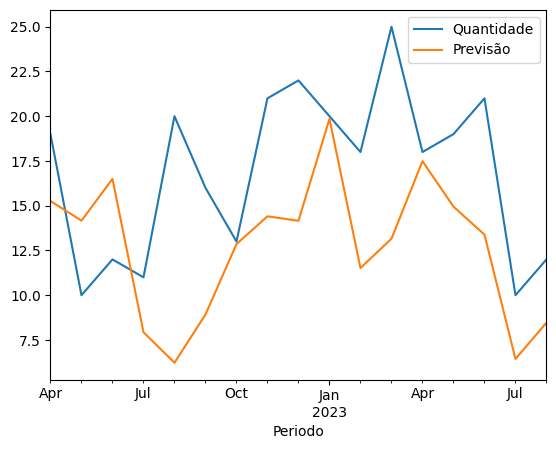

In [65]:
# Unindo os dados real x projetado
Juntando_Bases = pd.concat([Dados_Teste, Base_Previsao], axis=1 )

# Plotando o gráfico
Juntando_Bases.plot();

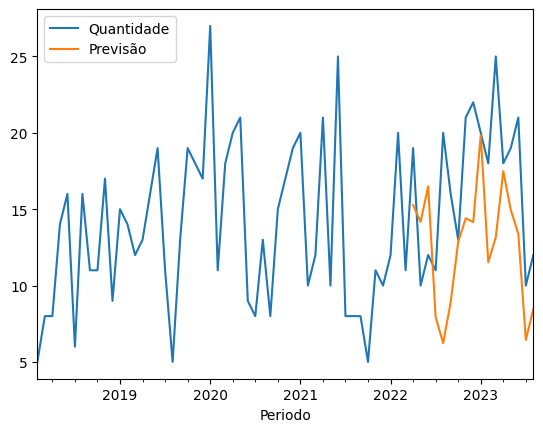

In [66]:
# Unindo os dados real x projetado
Juntando_Bases_02 = pd.concat([Base_Feminicídio['Quantidade'], Base_Previsao], axis=1 )

# Plotando o gráfico
Juntando_Bases_02.plot();

In [67]:
# Função para calcular o erro médio quadratico
from sklearn.metrics import mean_squared_error
# Calculando o erro médio do modelo
mean_squared_error(Dados_Teste, Previsao)

40.456331283377644

In [68]:
# --- Prevendo os próximos meses
# Treinando o Modelo com os dados de treino
Funcao_Auto_Arima.fit( Base_Feminicídio['Quantidade'] )

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [69]:
# Fazendo a previsão até o final do Ano
Previsao_Final_Ano = Funcao_Auto_Arima.predict( n_periods=6 )

In [70]:
# Lista para receeber as datas Futuas
Lista_Datas_Futuras = []

# Loop para gerar as datas
for Loop in range(7,13):
  # Somando as datas
  Proxima_Data = Registro_Inicial + relativedelta(month=Loop)

  # Salvando na Lista
  Lista_Datas_Futuras.append( Proxima_Data )

In [71]:
# Incluindo os dados de previsão em um data frame
Base_Futura = pd.DataFrame( Previsao_Final_Ano, index=Lista_Datas_Futuras, columns=['Futuro'])

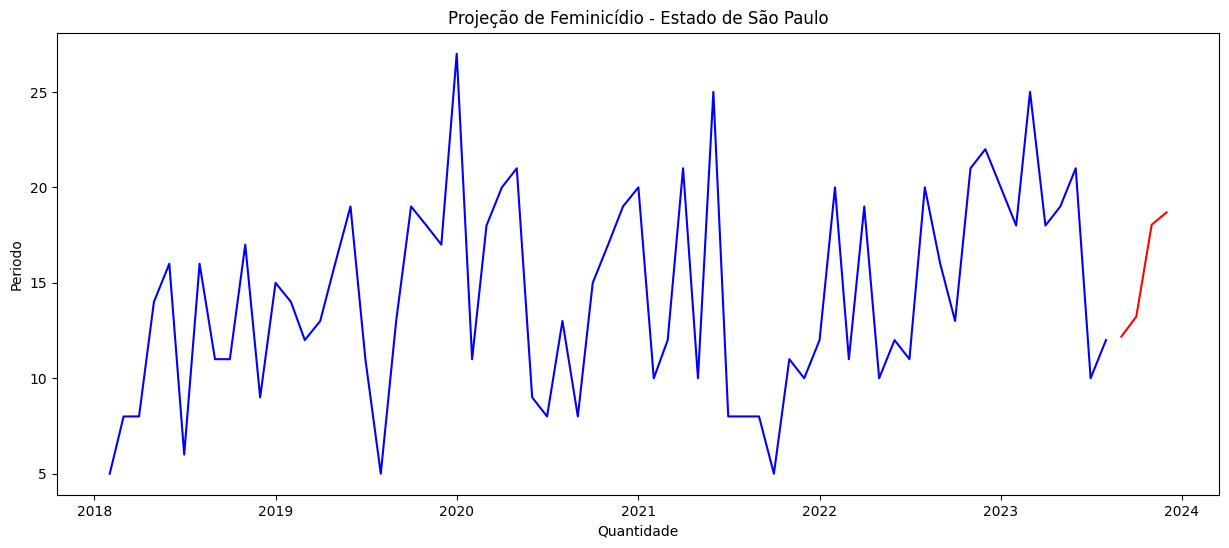

In [72]:
# Plotar o historio com o realizado
plt.figure( figsize=(15,6) )
plt.title('Projeção de Feminicídio - Estado de São Paulo')
plt.xlabel('Quantidade')
plt.ylabel('Periodo')
plt.plot( Base_Feminicídio['Quantidade'], color='blue' )
plt.plot( Base_Futura, color='red' );

In [73]:
# Importando as Libs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [74]:
# Vericar 5 primeiras linhas
Base_Dados =Base_Feminicídio

In [75]:
# Ultimas linhas
Base_Dados.tail()

,Rotulo,Quantidade
Periodo,,
2023-04-01,FEMINICÍDIO,18
2023-05-01,FEMINICÍDIO,19
2023-06-01,FEMINICÍDIO,21
2023-07-01,FEMINICÍDIO,10
2023-08-01,FEMINICÍDIO,12


In [76]:
# Verificar nulos
Base_Dados.isnull().sum()

Rotulo        0
Quantidade    0
dtype: int64

In [77]:
# Analisando os campos
Base_Dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2018-02-01 to 2023-08-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Rotulo      67 non-null     object
 1   Quantidade  67 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [78]:
# Converter de Objeto para Numerico
Base_Dados['Quantidade'] = pd.to_numeric( Base_Dados['Quantidade'] )

In [82]:
Dados = Base_Dados

In [83]:
# Retirando a coluna Rotulo
Dados.drop( columns='Rotulo', inplace=True )
Dados.head()

,Quantidade
Periodo,
2018-02-01,5
2018-03-01,8
2018-04-01,8
2018-05-01,14
2018-06-01,16


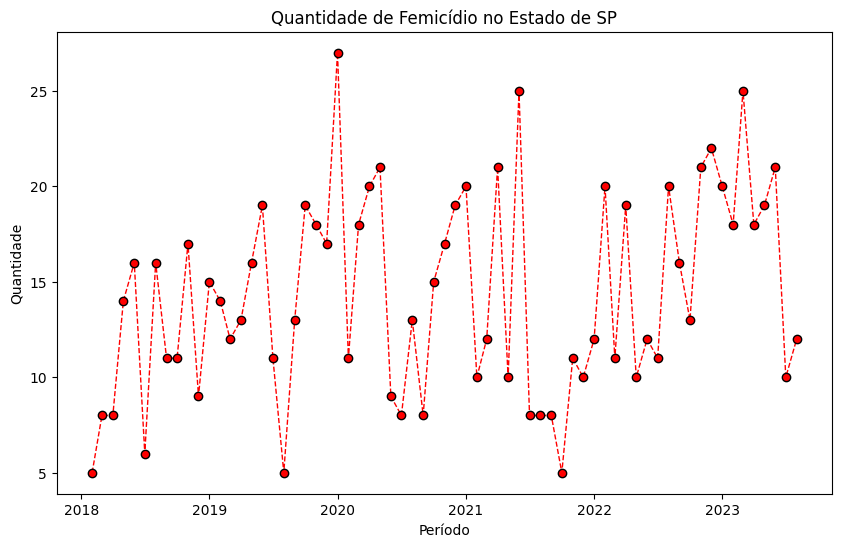

In [84]:
# Matplot - Linhas
plt.figure( figsize=(10, 6) ) # Tamanho
plt.title('Quantidade de Femicídio no Estado de SP') # titulo
plt.xlabel('Período') # Rotulo x
plt.ylabel('Quantidade') # Rotulo y
plt.plot( Dados, color='red', linewidth=1, marker='o', linestyle='dashed', markeredgecolor='black'  );

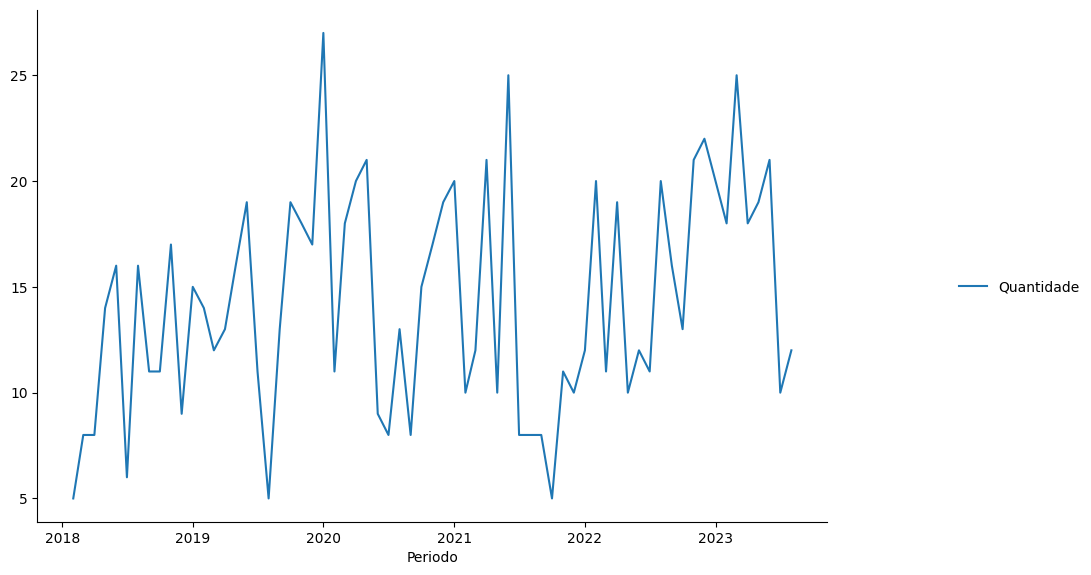

In [85]:
# Seaborn - Linhas
sns.relplot( data=Dados, kind='line')
plt.gcf().set_size_inches(12, 6)

In [86]:
# Plotly - Linhas
px.line(Dados, y='Quantidade', x=Dados.index, width = 700, height = 500, title = 'Gráfico de Linha' )

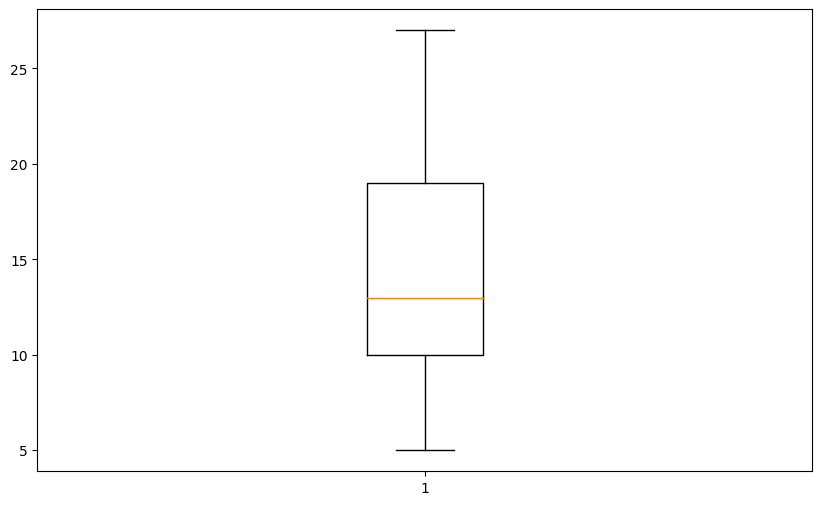

In [87]:
# Boxplot - Matplotlib
plt.figure( figsize=(10, 6) ) # Tamanho
plt.boxplot( x=Dados['Quantidade'] );

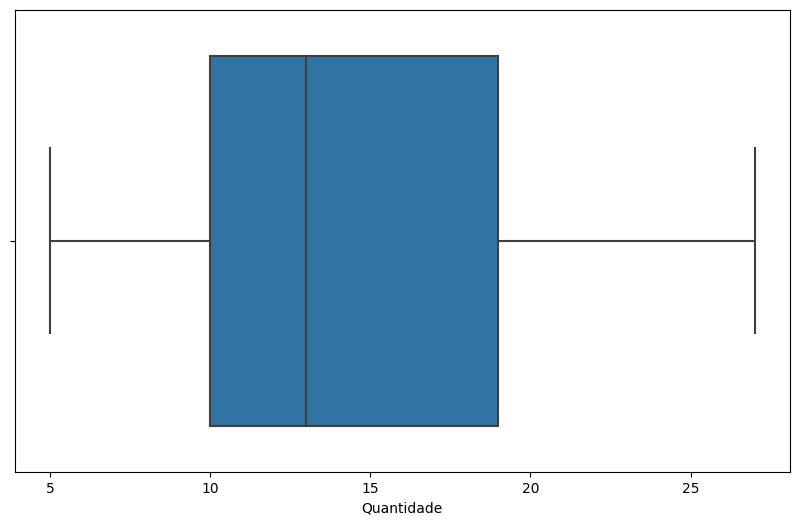

In [88]:
# Seaborn - boxplot
sns.boxplot( x=Dados['Quantidade'] )
plt.gcf().set_size_inches(10, 6);

In [89]:
# Plotly - boxplot
px.box( Dados, y='Quantidade', width=600, height=500 )

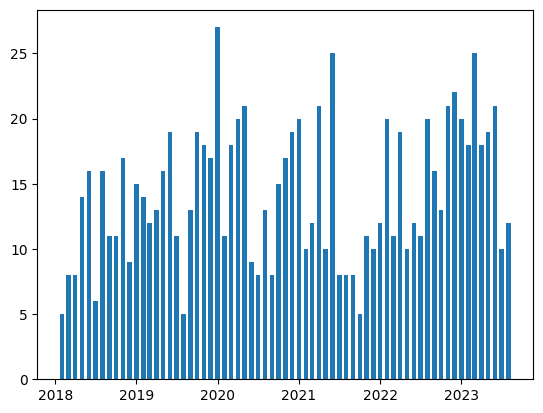

In [90]:
# Matplot - Barras
plt.bar( Dados.index, Dados['Quantidade'], width=20 );

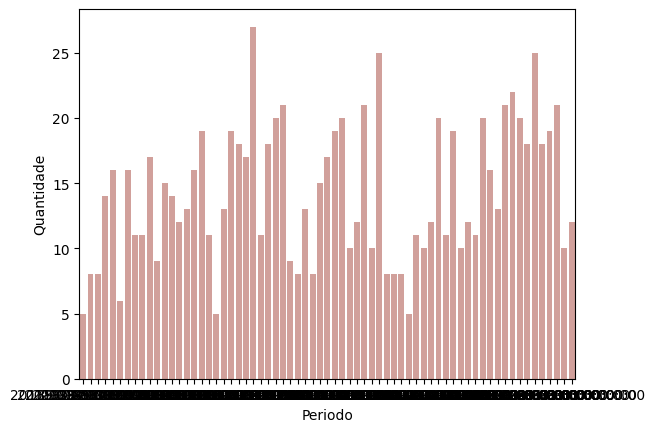

In [91]:
# Seaborn - Barras
sns.barplot( x=Dados.index, y='Quantidade', data=Dados, color='salmon', saturation=0.4 );

In [92]:
# Plotly - Barras
px.bar(Dados, x=Dados.index, y='Quantidade')

In [93]:
# Média movel de 3 dias

# Ordenar os indices
Dados = Dados.sort_index()

# Calcular a média móvel
Dados['Média Movel'] = Dados.rolling(3).mean()

Dados.head()

,Quantidade,Média Movel
Periodo,,
2018-02-01,5,NaN
2018-03-01,8,NaN
2018-04-01,8,7.000000
2018-05-01,14,10.000000
2018-06-01,16,12.666667


<ipython-input-94-fbb139373bc0>:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



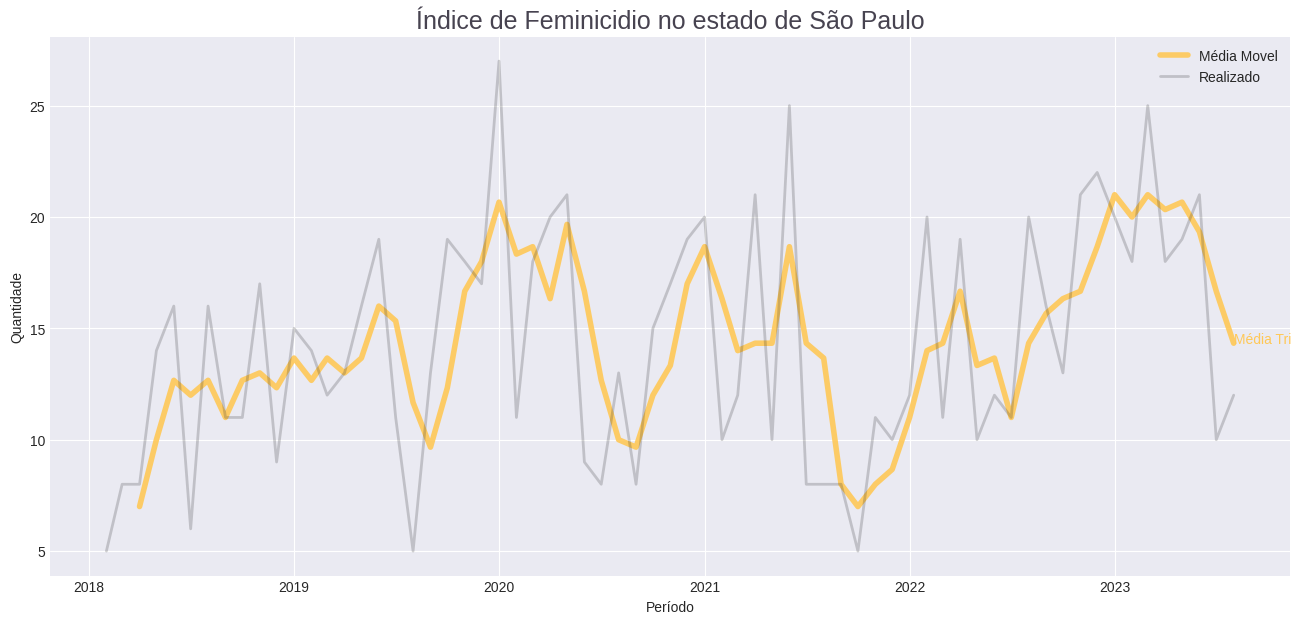

In [94]:
# Change the style of plot
plt.style.use('seaborn-darkgrid')

# setando o tamanho da figura
plt.figure( figsize=(16, 7))

# Plotando a ação da B3 para ficar destacada
plt.plot( Dados.index, Dados['Média Movel'], marker='', color='#ffc857', linewidth=4, alpha=0.9)

# Plotando o nome da B3 no gráfico
plt.text( Dados.index[-1] , Dados['Média Movel'].tail(1), 'Média Tri', horizontalalignment='left', size='medium', color='#ffc857');

# Plotando a ação espeficifico
plt.plot( Dados.index, Dados['Quantidade'], marker='', color='#1c1c1c', linewidth=2, alpha=0.2)

# Definindo o titulo
plt.title( 'Índice de Feminicidio no estado de São Paulo',
          loc='center', fontsize=18, fontweight=0, color='#474350')

# Definindo os Labels
plt.xlabel('Período')
plt.ylabel('Quantidade')

plt.legend( ['Média Movel', 'Realizado'] );